<a href="https://colab.research.google.com/github/alexanderportilla96/Proyecto-SyS_-PROYECTO_FINAL_GIGA_SCIENCE_EEGMI_GCPDS/blob/main/2_2_Relacion_TZ_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.2 Con base en el estudio de la transformada Z y el diseno de filtros digitales presentado en el cuaderno Transformada Z, explique en que consisten los filtros FIR e IIR, y como se utilizan para resaltar patrones espaciales, temporales y espectrales desde señales EEG en tareas de MI.


### 1. Fundamentos: Diferencia entre Filtros FIR e IIR

Desde la perspectiva de la **Transformada Z**, la diferencia fundamental radica en la ubicación de los polos y ceros y en cómo el sistema procesa las muestras pasadas.

#### Filtros FIR (Finite Impulse Response)
Son filtros de **Respuesta al Impulso Finita**.
* **Matemáticamente:** Su función de transferencia $H(z)$ es un polinomio que solo tiene ceros (los polos están en el origen $z=0$).

$$H(z) = \sum_{k=0}^{M} b_k z^{-k}$$


* **Características Clave:**
    * **No son recursivos:** La salida depende solo de la entrada actual y las pasadas, *no* de salidas anteriores.
    * **Estabilidad:** Siempre son estables porque no tienen polos fuera del círculo unitario.
    * **Fase Lineal:** Pueden diseñarse para tener fase lineal exacta, lo cual es crítico para **no distorsionar la forma de la onda** en el dominio del tiempo.


#### Filtros IIR (Infinite Impulse Response)
Son filtros de **Respuesta al Impulso Infinita**.
* **Matemáticamente:** Su función de transferencia $H(z)$ es una función racional con polos y ceros.


$$H(z) = \frac{\sum_{k=0}^{M} b_k z^{-k}}{1 - \sum_{k=1}^{N} a_k z^{-k}}$$
* **Características Clave:**
    * **Recursivos:** La salida depende de las entradas y de las *salidas anteriores* (retroalimentación).
    * **Eficiencia:** Requieren mucho menos orden (menos coeficientes) que un FIR para lograr el mismo corte de frecuencia, lo que los hace computacionalmente más ligeros.
    * **Fase No Lineal:** Introducen distorsión de fase (retrasos desiguales en diferentes frecuencias), lo cual puede deformar la señal EEG a menos que se compense.





### 2. Aplicación en Tareas de Imaginería Motora (MI)

En el contexto del proyecto de GigaScience y Kaggle sobre Imaginería Motora, el objetivo es detectar cuándo el sujeto *imagina* mover una extremidad. Esto genera cambios conocidos como **ERD/ERS** (Desincronización/Sincronización Relacionada con Eventos). Los filtros digitales se utilizan para resaltar estos patrones así:

#### A. Resaltado de Patrones Espectrales (Frecuencia)
La Imaginería Motora ocurre principalmente en dos bandas de frecuencia: **Mu (8-13 Hz)** y **Beta (13-30 Hz)**. El ruido (parpadeo, tensión muscular, red eléctrica) está en otras frecuencias.

* **Uso del Filtro:** Se aplica un filtro **Pasa-Banda (Bandpass)**, generalmente entre 8 Hz y 30 Hz.
* **Elección IIR vs FIR:**
    * A menudo se prefiere un **IIR Butterworth** por su respuesta plana en la banda de paso y bajo coste computacional.
    * **Nota Crítica:** Como el IIR distorsiona la fase, en el procesamiento offline (como en los cuadernos de Python) se utiliza un filtrado **hacia adelante y hacia atrás** (función `scipy.signal.filtfilt`). Esto cancela la distorsión de fase, logrando un filtrado de "fase cero", preservando la estructura temporal exacta de los datos.

#### B. Resaltado de Patrones Temporales (Tiempo)
Necesitamos saber *cuándo* ocurre la imaginación motora.
* Al filtrar la señal y eliminar el ruido de baja frecuencia (drift) y alta frecuencia (EMG), la señal resultante muestra claramente la **envolvente de energía**.
* Durante la tarea de MI, la amplitud de las ondas en la banda Mu disminuye (ERD). Un filtro con fase lineal (o IIR compensado) asegura que el momento detectado de esta caída de energía coincida exactamente con el momento real en que el cerebro procesó la orden, sin retrasos artificiales.

#### C. Resaltado de Patrones Espaciales (Ubicación)
Aunque los filtros FIR/IIR son temporales, son el prerrequisito para el análisis espacial.
* La MI activa zonas específicas: **C3 (hemisferio izquierdo)** para mano derecha y **C4 (hemisferio derecho)** para mano izquierda.


[Image of EEG electrode placement 10-20 system]

* Si no aplicamos primero un filtro digital (FIR o IIR) para limpiar la señal, los algoritmos espaciales como **CSP (Common Spatial Patterns)** —que son estándar en el proyecto que mencionas— fallarían. El CSP busca maximizar la varianza de una clase vs. la otra; si la señal tiene ruido fuera de las bandas Mu/Beta, el CSP maximizará el ruido en lugar de la señal cerebral.

### Resumen de la Estrategia en el Proyecto

1.  **Diseño:** Se diseñan filtros (usualmente IIR Butterworth de orden 4 o 5) usando la ubicación de polos y ceros en el plano Z para definir las frecuencias de corte (8-30 Hz).
2.  **Filtrado:** Se aplica el filtro a cada canal del EEG para aislar los ritmos motores.
3.  **Procesamiento:** La señal limpia alimenta los algoritmos de extracción de características (CSP) y clasificación (LDA/SVM).

**¿Te gustaría que generara el código en Python (usando `scipy.signal`) para diseñar y comparar un filtro FIR y un IIR aplicados a una señal de prueba simulada?**

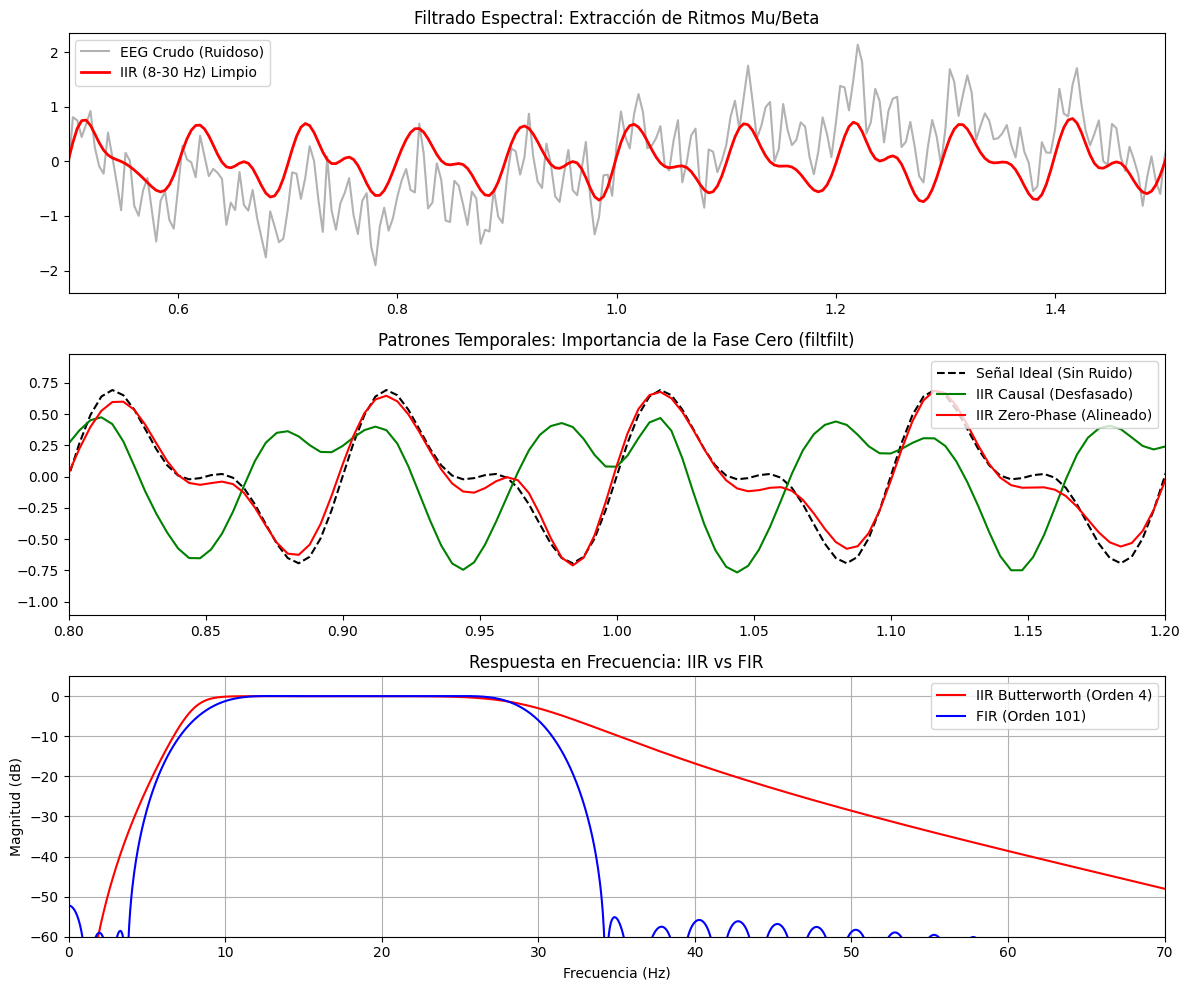

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# 1. Configuración de la simulación
fs = 250.0  # Frecuencia de muestreo típica (Hz)
T = 2.0     # Duración (segundos)
t = np.linspace(0, T, int(T * fs), endpoint=False)

# 2. Generar señal sintética "tipo EEG" para Imaginería Motora (MI)
# Señal deseada: Ritmo Mu (10 Hz) y Beta (20 Hz)
sig_mi = 0.5 * np.sin(2 * np.pi * 10 * t) + 0.3 * np.sin(2 * np.pi * 20 * t)

# Ruido/Artefactos a eliminar:
noise_drift = 0.8 * np.sin(2 * np.pi * 1 * t)  # Baja frecuencia (movimiento)
noise_line = 0.4 * np.sin(2 * np.pi * 60 * t)  # 60 Hz (red eléctrica)
raw_eeg = sig_mi + noise_drift + noise_line + 0.2 * np.random.randn(len(t))

# ---------------------------------------------------------
# 3. DISEÑO DE FILTROS (Banda de paso: 8-30 Hz)
# ---------------------------------------------------------

# A. Filtro IIR (Butterworth)
# Eficiente, orden bajo, pero distorsiona fase si no se cuida.
nyquist = 0.5 * fs
low = 8.0 / nyquist
high = 30.0 / nyquist
b_iir, a_iir = signal.butter(4, [low, high], btype='band')

# B. Filtro FIR (Window method)
# Fase lineal, siempre estable, pero requiere orden alto.
numtaps = 101  # Cantidad de coeficientes
b_fir = signal.firwin(numtaps, [8.0, 30.0], pass_zero=False, fs=fs)
a_fir = 1.0     # Denominador es 1 en FIR

# ---------------------------------------------------------
# 4. APLICACIÓN DEL FILTRADO
# ---------------------------------------------------------

# Caso 1: IIR Estándar (lfilter)
# Introduce un cambio de fase (retraso no lineal).
filtered_iir = signal.lfilter(b_iir, a_iir, raw_eeg)

# Caso 2: IIR Fase Cero (filtfilt) - CRÍTICO EN ANÁLISIS OFFLINE
# Filtra hacia adelante y hacia atrás. Elimina distorsión de fase.
filtered_filtfilt = signal.filtfilt(b_iir, a_iir, raw_eeg)

# Caso 3: FIR (lfilter)
# Introduce un retraso constante (Fase lineal).
filtered_fir = signal.lfilter(b_fir, a_fir, raw_eeg)

# ---------------------------------------------------------
# 5. VISUALIZACIÓN DE RESULTADOS
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))

# Gráfica A: Señal Crudo vs Filtrada (Efecto Espectral)
plt.subplot(3, 1, 1)
plt.plot(t, raw_eeg, 'k', alpha=0.3, label='EEG Crudo (Ruidoso)')
plt.plot(t, filtered_filtfilt, 'r', linewidth=2, label='IIR (8-30 Hz) Limpio')
plt.title('Filtrado Espectral: Extracción de Ritmos Mu/Beta')
plt.legend()
plt.xlim(0.5, 1.5) # Zoom en 1 segundo

# Gráfica B: Comparación Temporal (Fase y Retardo)
plt.subplot(3, 1, 2)
plt.plot(t, sig_mi, 'k--', label='Señal Ideal (Sin Ruido)')
plt.plot(t, filtered_iir, 'g', label='IIR Causal (Desfasado)')
plt.plot(t, filtered_filtfilt, 'r', label='IIR Zero-Phase (Alineado)')
plt.title('Patrones Temporales: Importancia de la Fase Cero (filtfilt)')
plt.legend(loc='upper right')
plt.xlim(0.8, 1.2) # Zoom grande para ver desfase

# Gráfica C: Respuesta en Frecuencia
w, h_iir = signal.freqz(b_iir, a_iir, worN=2000)
_, h_fir = signal.freqz(b_fir, a_fir, worN=2000)
freqs = (fs * 0.5 / np.pi) * w

plt.subplot(3, 1, 3)
plt.plot(freqs, 20 * np.log10(abs(h_iir)), 'r', label='IIR Butterworth (Orden 4)')
plt.plot(freqs, 20 * np.log10(abs(h_fir)), 'b', label=f'FIR (Orden {numtaps})')
plt.title('Respuesta en Frecuencia: IIR vs FIR')
plt.ylabel('Magnitud (dB)')
plt.xlabel('Frecuencia (Hz)')
plt.xlim(0, 70)
plt.ylim(-60, 5)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show() # Si corres esto localmente